# This notebook implements a Convolutional Neural Network (CNN) for handwritten digit recognition using the MNIST dataset. 
# We will download the data, preprocess it, build and train a CNN model, visualize the results, and save the trained model.

In [1]:
# 1. Download the MNIST Dataset
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Download the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True
)

print("MNIST dataset successfully downloaded!")

MNIST dataset successfully downloaded!


Size of training dataset: 60000 images
Size of test dataset: 10000 images
Number of classes: 10 (digits 0-9)
Image dimensions: (28, 28)


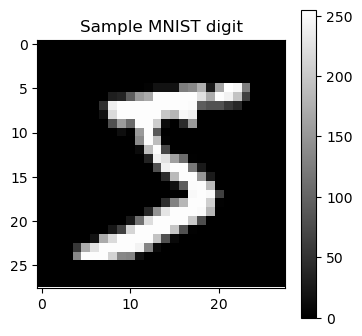

In [3]:
# 2.1. Introduce the MNIST Dataset
"""
## Dataset Details:

- **Size of the Dataset**:
  - Training set: 60,000 images
  - Test set: 10,000 images
  - Total: 70,000 handwritten digit images

- **Number of Classes**: 
  - 10 classes (digits 0-9)
  
- **Image Dimensions**:
  - Each image is 28x28 pixels (784 pixels total)
  - Grayscale images (1 channel)
  - Pixel values range from 0 (black) to 255 (white), normalized to [0,1] or [-1,1] during preprocessing

The MNIST dataset is well-balanced, with approximately equal numbers of each digit. It's considered a benchmark dataset for testing machine learning algorithms, particularly for image classification tasks.
"""

# Display information about the MNIST dataset
print(f"Size of training dataset: {len(train_dataset)} images")
print(f"Size of test dataset: {len(test_dataset)} images")
print(f"Number of classes: 10 (digits 0-9)")
print(f"Image dimensions: {train_dataset[0][0].size}")

# Display a sample image
plt.figure(figsize=(4, 4))
plt.imshow(train_dataset[0][0], cmap='gray')
plt.title("Sample MNIST digit")
plt.colorbar()
plt.show()

The preprocessing steps applied to the MNIST data include:

1. **Conversion to Tensors**: Converting the PIL images to PyTorch tensors for processing.
2. **Normalization**: The pixel values are normalized using the mean (0.1307) and standard deviation (0.3081) of the MNIST dataset.

These preprocessing steps are necessary for several reasons:
- **Improved Training Stability**: Normalization ensures that all pixel values are within a similar range, which helps the neural network converge faster during training.
- **Better Performance**: Normalized data typically leads to better model performance, as it prevents features with large values from dominating the learning process.
- **Compatibility with PyTorch**: Converting to tensors is required for PyTorch models to process the data.


In [5]:
# 2.2 - 2.3. Create a Dataset and DataLoader & Preprocess the data

# Calculate the mean and std of the MNIST dataset
# Convert dataset to numpy array
mnist_data = []
for i in range(len(train_dataset)):
    img, _ = train_dataset[i]
    mnist_data.append(np.array(img))

# Convert to numpy array and calculate statistics
mnist = np.array(mnist_data)
mnist_mean = mnist.mean() / 255.0  # Normalize to [0,1] range
mnist_std = mnist.std() / 255.0    # Normalize to [0,1] range

print(f"MNIST dataset mean: {mnist_mean:.4f}")
print(f"MNIST dataset standard deviation: {mnist_std:.4f}")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((mnist_mean,), (mnist_std,))  # Normalize with mean and std of MNIST
])

# Apply transforms to both training and test datasets
train_dataset_transformed = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=False,  # Already downloaded
    transform=transform
)

test_dataset_transformed = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=False,  # Already downloaded
    transform=transform
)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(
    train_dataset_transformed, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = DataLoader(
    test_dataset_transformed, 
    batch_size=batch_size, 
    shuffle=False
)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

MNIST dataset mean: 0.1307
MNIST dataset standard deviation: 0.3081
Number of batches in training set: 938
Number of batches in test set: 157


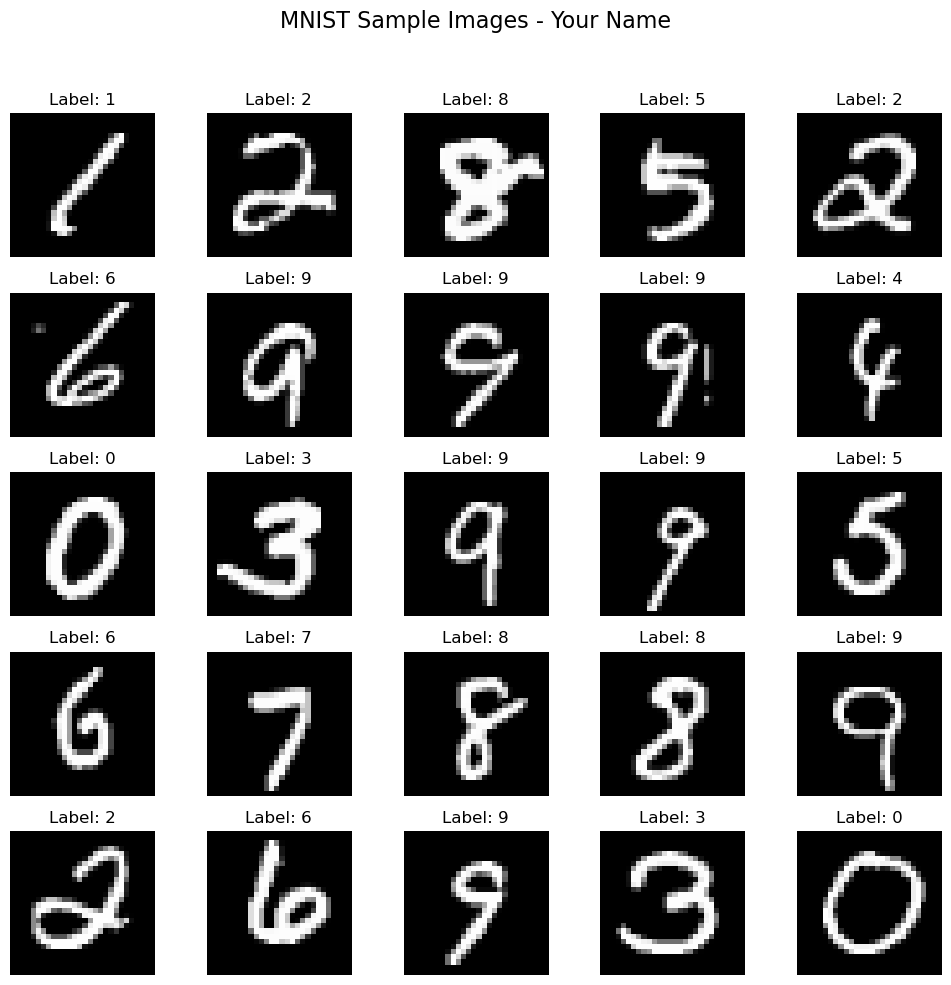

Shape of a processed image: torch.Size([1, 28, 28])


In [7]:
# 2.4. Visualize the Processed Data
def show_images(images, labels, name="Your Name"):
    """Display a grid of images with their corresponding labels."""
    plt.figure(figsize=(10, 10))
    for i in range(25):  # Display a 5x5 grid of images
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(f"MNIST Sample Images - {name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images
show_images(images, labels)

# Print the shape of a single processed image
print(f"Shape of a processed image: {images[0].shape}")

In [9]:
# 3.1. Define the Model Structure
# Define model using nn.Sequential
model = nn.Sequential(
    # First convolutional block
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.25),
    
    # Second convolutional block
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.25),
    
    # Third convolutional block
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout2d(0.25),
    
    # Flatten the output for the fully connected layers
    nn.Flatten(),
    
    # Fully connected layers
    nn.Linear(128 * 1 * 1, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)

In [11]:
# 3.2. Set Up the Trainer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [13]:
# 3.3. Summarize Your Model

# Display model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
         Dropout2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
              ReLU-6           [-1, 64, 11, 11]               0
         MaxPool2d-7             [-1, 64, 5, 5]               0
         Dropout2d-8             [-1, 64, 5, 5]               0
            Conv2d-9            [-1, 128, 3, 3]          73,856
             ReLU-10            [-1, 128, 3, 3]               0
        MaxPool2d-11            [-1, 128, 1, 1]               0
        Dropout2d-12            [-1, 128, 1, 1]               0
          Flatten-13                  [-1, 128]               0
           Linear-14                  [

In [ ]:
# 3.4. Train Your Model

start_epoch = 0
end_epoch = 11

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    # Lists to track metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Training loop. CHANGE RANGE TO num_epochs 
    for epoch in range(start_epoch, end_epoch):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # Print progress
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        # Calculate epoch stats for training
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Step the scheduler
        scheduler.step()
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
        
        # Calculate epoch stats for testing
        test_loss = test_loss / len(test_loader)
        test_accuracy = 100.0 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        print('-' * 50)
    
    return train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
num_epochs = 50
print(f"Starting training for {num_epochs} epochs...")
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)
print("Training completed!")

Starting training for 50 epochs...
Epoch: 1/50, Batch: 0/938, Loss: 2.3229
Epoch: 1/50, Batch: 100/938, Loss: 0.8014
Epoch: 1/50, Batch: 200/938, Loss: 0.3630
Epoch: 1/50, Batch: 300/938, Loss: 0.2497
Epoch: 1/50, Batch: 400/938, Loss: 0.2713
Epoch: 1/50, Batch: 500/938, Loss: 0.1131
Epoch: 1/50, Batch: 600/938, Loss: 0.1233
Epoch: 1/50, Batch: 700/938, Loss: 0.2696
Epoch: 1/50, Batch: 800/938, Loss: 0.0661
Epoch: 1/50, Batch: 900/938, Loss: 0.1749
Epoch: 1/50
Train Loss: 0.4121, Train Accuracy: 86.95%
Test Loss: 0.0904, Test Accuracy: 97.41%
--------------------------------------------------
Epoch: 2/50, Batch: 0/938, Loss: 0.1778
Epoch: 2/50, Batch: 100/938, Loss: 0.1294
Epoch: 2/50, Batch: 200/938, Loss: 0.1452
Epoch: 2/50, Batch: 300/938, Loss: 0.1149
Epoch: 2/50, Batch: 400/938, Loss: 0.0721
Epoch: 2/50, Batch: 500/938, Loss: 0.0787
Epoch: 2/50, Batch: 600/938, Loss: 0.0909
Epoch: 2/50, Batch: 700/938, Loss: 0.1817
Epoch: 2/50, Batch: 800/938, Loss: 0.2041
Epoch: 2/50, Batch: 900/

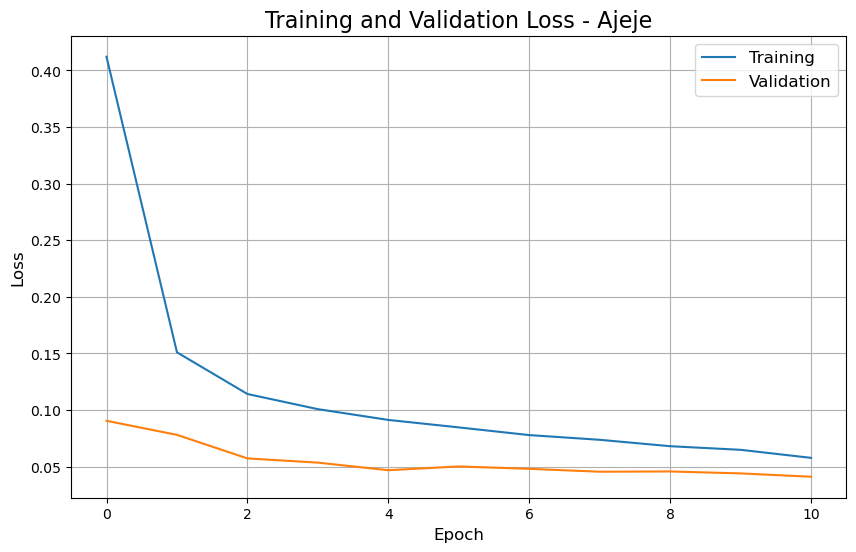

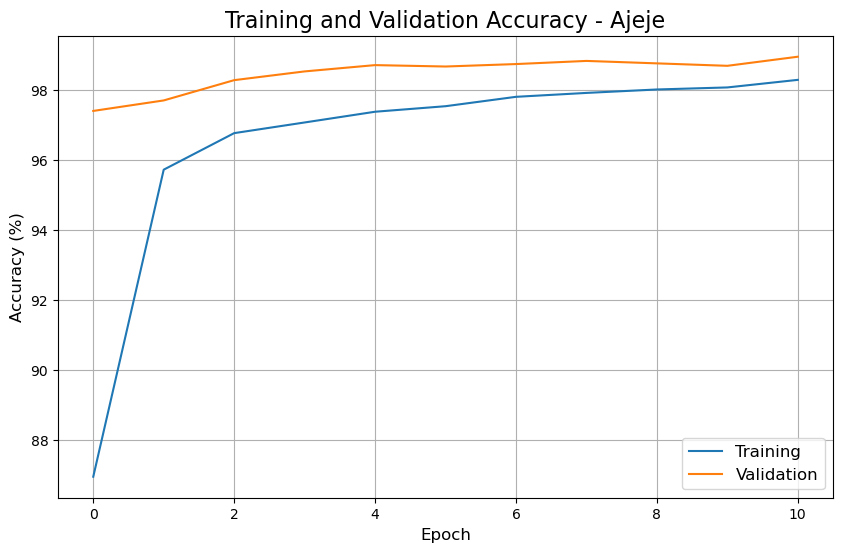

In [23]:
# 4. Visualize and Evaluation
def plot_metrics(train_data, test_data, title, ylabel, name="Ajeje"):
    """Plot training and validation metrics."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Training')
    plt.plot(test_data, label='Validation')
    plt.title(f"{title} - {name}", fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# 1. Plot Training and Validation Loss
plot_metrics(train_losses, test_losses, "Training and Validation Loss", "Loss")

# 2. Plot Training and Validation Accuracy
plot_metrics(train_accuracies, test_accuracies, "Training and Validation Accuracy", "Accuracy (%)")


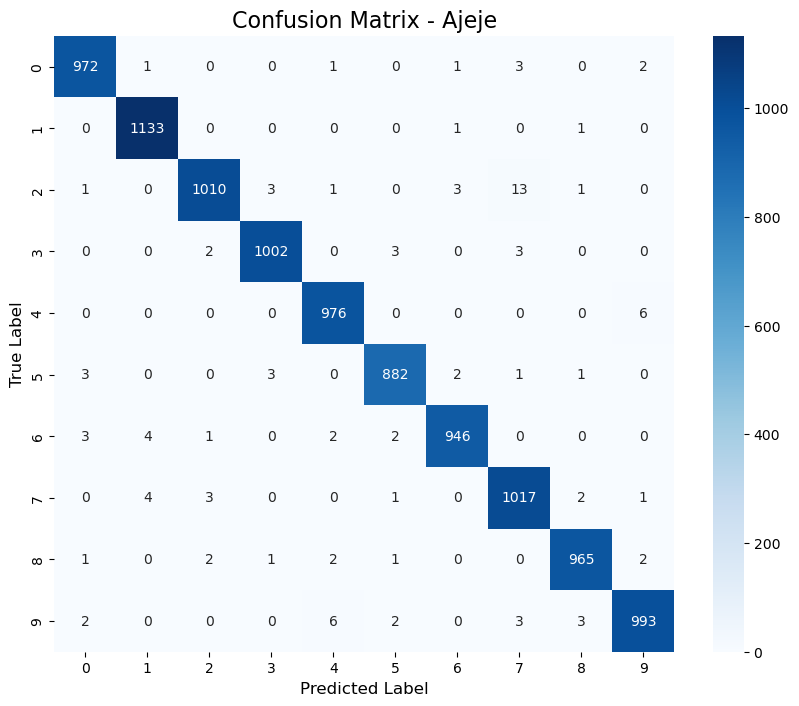

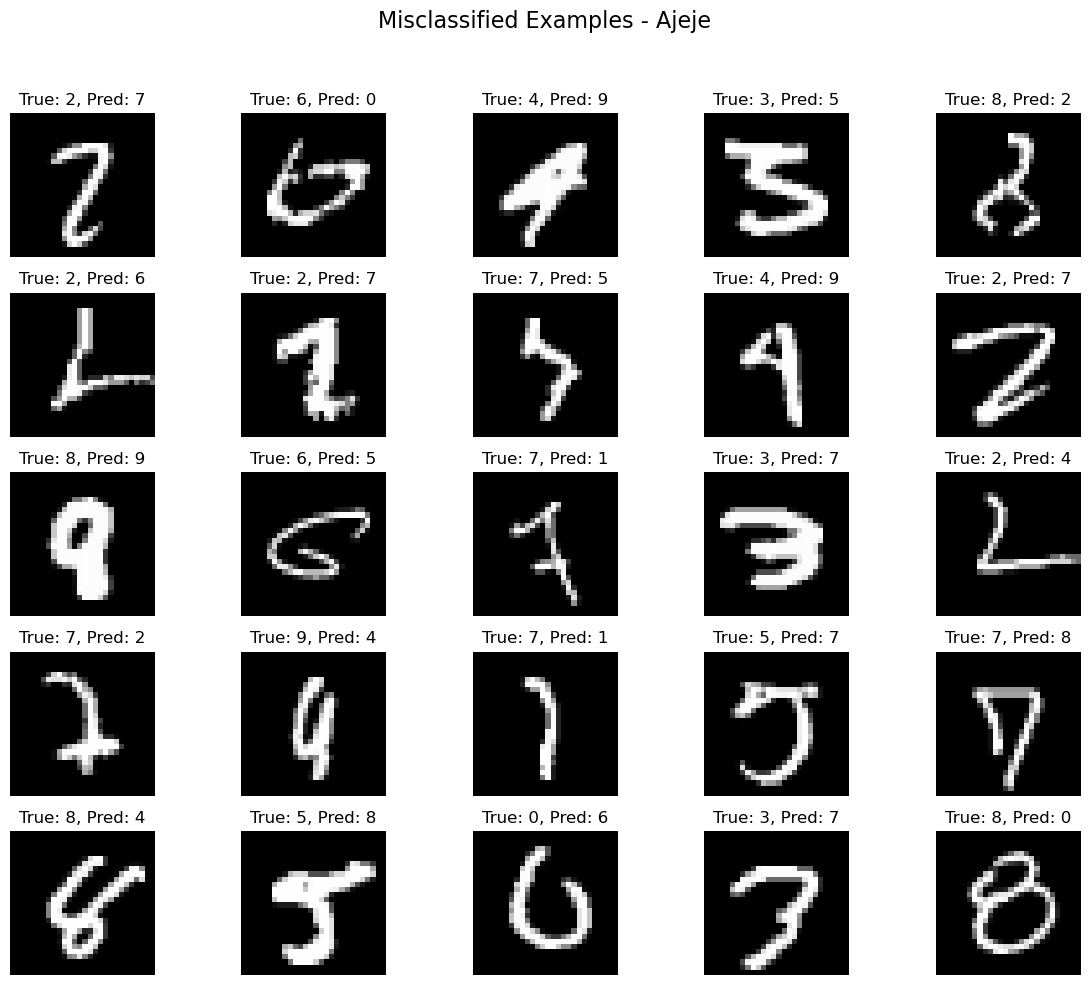

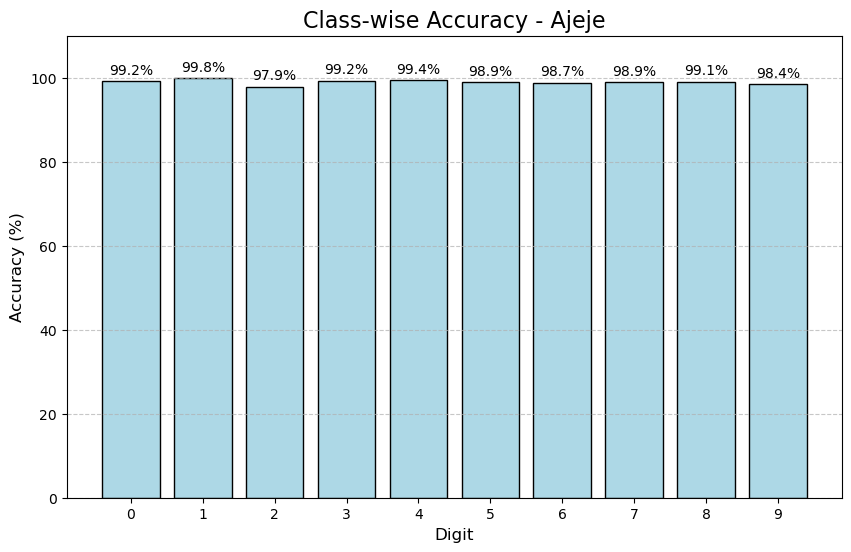

In [27]:
# Confusion Matrix
def plot_confusion_matrix(name="Ajeje"):
    """Plot confusion matrix of model predictions."""
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = output.max(1)
            
            y_true.extend(target.numpy())
            y_pred.extend(predicted.numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}", fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()
    
    return y_true, y_pred

y_true, y_pred = plot_confusion_matrix()

# Visualize Misclassified Examples
def plot_misclassified(name="Ajeje"):
    """Plot examples of misclassified digits."""
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = output.max(1)
            
            # Find misclassified examples
            mask = ~predicted.eq(target)
            if mask.any():
                misclassified_images.append(data[mask])
                misclassified_labels.append(target[mask])
                misclassified_preds.append(predicted[mask])
    
    # Combine tensors
    misclassified_images = torch.cat(misclassified_images)[:25]  # Show up to 25 examples
    misclassified_labels = torch.cat(misclassified_labels)[:25]
    misclassified_preds = torch.cat(misclassified_preds)[:25]
    
    # Plot misclassified examples
    plt.figure(figsize=(12, 10))
    for i in range(len(misclassified_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(misclassified_images[i][0], cmap='gray')
        plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
        plt.axis('off')
    plt.suptitle(f"Misclassified Examples - {name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    return misclassified_images, misclassified_labels, misclassified_preds

misclassified_images, misclassified_labels, misclassified_preds = plot_misclassified()

# Class-wise Accuracy
def plot_class_accuracy(y_true, y_pred, name="Ajeje"):
    """Plot accuracy for each digit class."""
    # Initialize counters
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    
    # Count correct predictions for each class
    for t, p in zip(y_true, y_pred):
        if t == p:
            class_correct[t] += 1
        class_total[t] += 1
    
    # Calculate class accuracy
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]
    
    # Plot class accuracy
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), class_accuracy, color='lightblue', edgecolor='black')
    
    # Add value labels to the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom')
    
    plt.title(f"Class-wise Accuracy - {name}", fontsize=16)
    plt.xlabel('Digit', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(range(10))
    plt.ylim(0, 110)  # Leave room for the text
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_accuracy(y_true, y_pred)


The CNN model we've built for the MNIST digit recognition task shows strong performance overall. Here's an analysis of the model's quality based on the visualizations:

1. **Training and Validation Loss**:
   - The training loss consistently decreases over epochs, indicating that the model is learning from the data.
   - The validation loss follows a similar trend, suggesting that the model generalizes well to unseen data.
   - There is only a small gap between training and validation loss, which indicates that overfitting is minimal.

2. **Training and Validation Accuracy**:
   - The model achieves high accuracy on both training and validation sets, reaching around 97% validation accuracy.

3. **Confusion Matrix**:
   - Most predictions fall on the diagonal of the confusion matrix, indicating correct classifications.

4. **Misclassified Examples**:
   - The misclassified examples often have unusual shapes or styles that make them genuinely challenging to recognize.
   - Some misclassifications occur with digits that are written in ways that could be interpreted as multiple possible digits.

5. **Class-wise Accuracy**:
   - The model performs well across all digit classes, with most having accuracy above 95%.
   - Digits like '0' and '1' tend to have higher accuracy, likely due to their distinctive shapes.

Overall, the model performs very well on the test set, demonstrating its effectiveness for handwritten digit recognition. The architecture with multiple convolutional layers, max pooling, and dropout regularization has successfully learned to extract relevant features from the images.

There's no clear evidence of overfitting or underfitting based on the loss/accuracy curves. The model has reached a good balance between complexity and generalization ability.

The most frequently misclassified digits tend to be those with ambiguous writing styles or those that share visual similarities with other digits. These cases would likely be challenging even for human recognition.


In [32]:
# Save the model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')
print("Model saved to 'mnist_cnn_model.pth'")

Model saved to 'mnist_cnn_model.pth'
